# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**____________

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

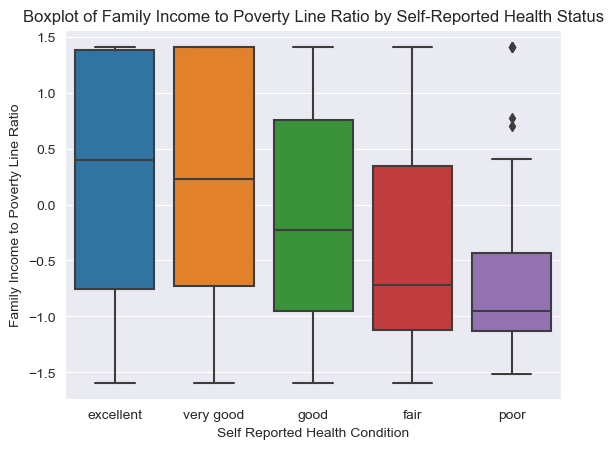

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

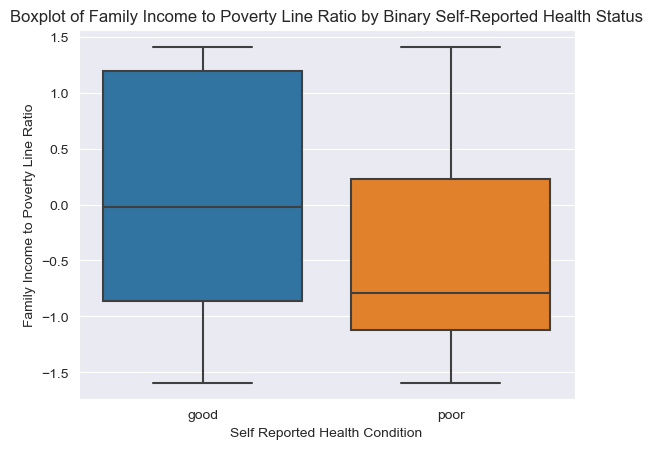

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

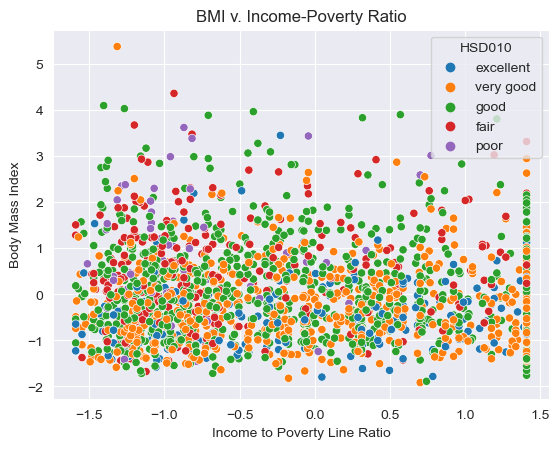

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [17]:
nhanes_scaled_dropped = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

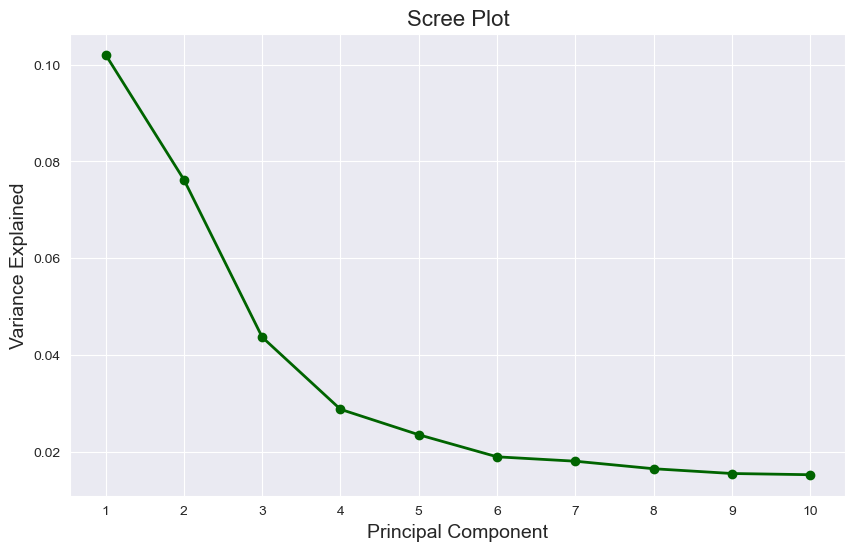

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA with 10 principal components
pca = PCA(n_components=10)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled_dropped)

# Scree plot
PC_values = np.arange(1, pca.n_components_ + 1)
plt.figure(figsize=(10, 6))
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='darkgreen')
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Explained', fontsize=14)
plt.xticks(PC_values)
plt.grid(True)
plt.show()




I chose ten components due to my work this semster on survey analysis where it was quite common to chose between 15 PCs. Allowing for this amount of PCs in survey analysis can help calrify the thematic trends of the PCs even when only a handful are most dominante. 

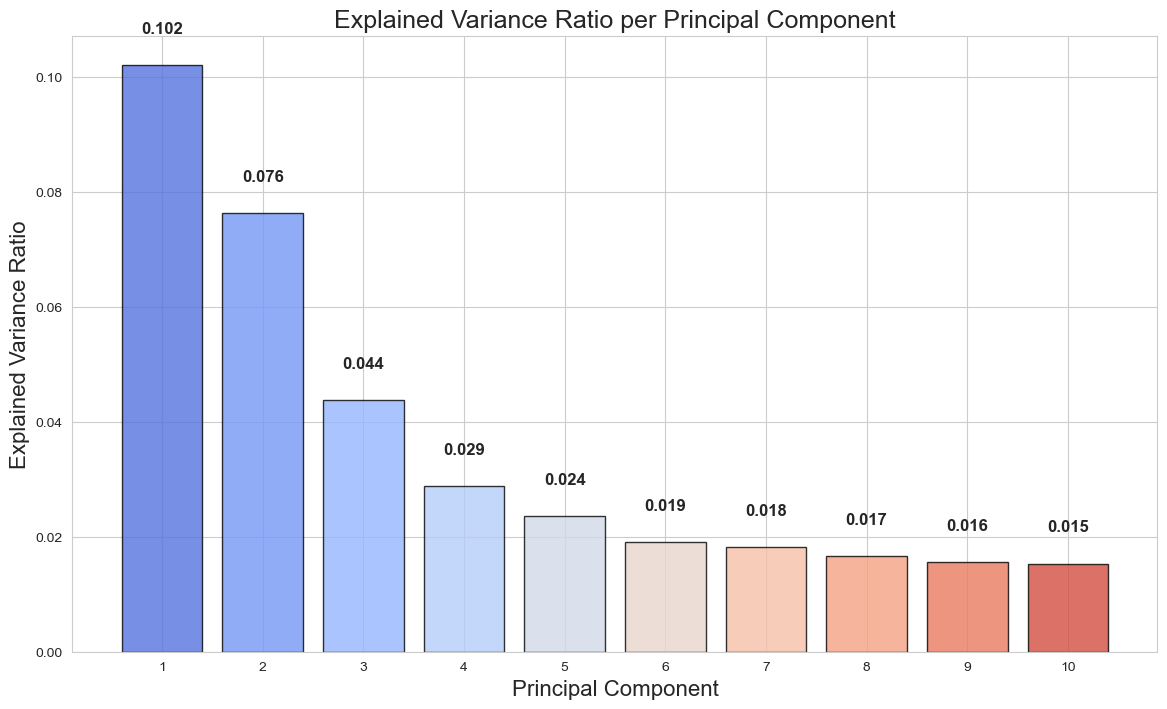

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style 
sns.set_style("whitegrid")

# Bar plot of explained variance ratios
explained_var_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(14, 8))
bars = plt.bar(PC_values, explained_var_ratio, color=sns.color_palette("coolwarm", 10), 
               alpha=0.8, edgecolor='black')

# Add labels and title with increased font size
plt.xlabel('Principal Component', fontsize=16)
plt.ylabel('Explained Variance Ratio', fontsize=16)
plt.title('Explained Variance Ratio per Principal Component', fontsize=18)
plt.xticks(PC_values)

# Adding value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 3), 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()


Ideally we would like to see a few PCs that dominate in terms ofvarition explained but this is not quite the case. Indeed while the forst two PCs are compartively higher they still do not explain much variation. However we can observe that after the third PC less than 5% of the variation for next subsequent PC. This means we get negligent benifet but any subsequent PCs. Thus we can pick 3 or 4 given the general lowe vaiation explained even by the most domiante PC.

### Barplot of Components

### 2D Scatterplot of the first two components

In [18]:
pca_df = pd.DataFrame(data = principalComponents_nhanes, index=nhanes_scaled_dropped.index)  

pca_sp = PCA(n_components=2)
principalComponents_nhanes_sp = pca_sp.fit_transform(pca_df)


# convert into a dataframe
# ----------
pca_df_sp = pd.DataFrame(data = principalComponents_nhanes_sp, 
                      columns = ['principal component 1', 
                                 'principal component 2'])


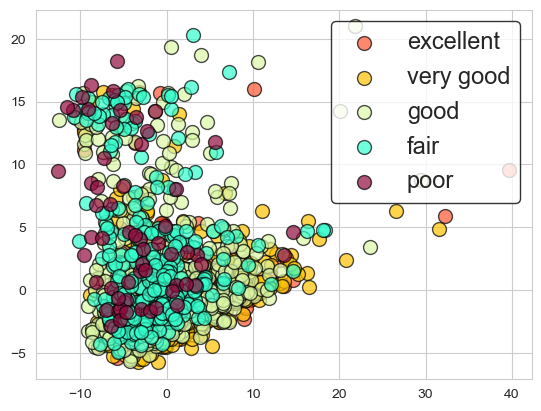

In [21]:
# Completing the gradient colors list
gradient_colors = ['#FF5733', '#FFC300', '#DAF7A6', '#33FFCE', '#900C3F']

# Plot Design
for target, color in zip(targets, gradient_colors):
    indicesToKeep = (nhanes_scaled['HSD010'] == target).reset_index(drop=True)
    plt.scatter(pca_df_sp.loc[indicesToKeep, 'principal component 1'],
                pca_df_sp.loc[indicesToKeep, 'principal component 2'], 
                c=color, s=100, edgecolor='black', alpha=0.7)

# Show Plot
plt.legend(targets, prop={'size': 17}, frameon=True, facecolor='white', edgecolor='black')
plt.show()



It is difficult to discern any clear pattern here. As a result we are more motivated to use PCA to disentangle these factors that are expereicing heavy multicoliniarity .

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

K-means helps identify predetermined number of "clusters" within an unlabelled dataset by using an repated method to produce a final clustering based on the number of clusters defined by the user. In K-means, each cluster is represented by its center , centroid, which corresponds to the arithmetic mean or center of data points assigned to the cluster. 

### Choose a Clustering Algorithm

/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jr/Desktop/anaconda3/envs/CSS/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureW

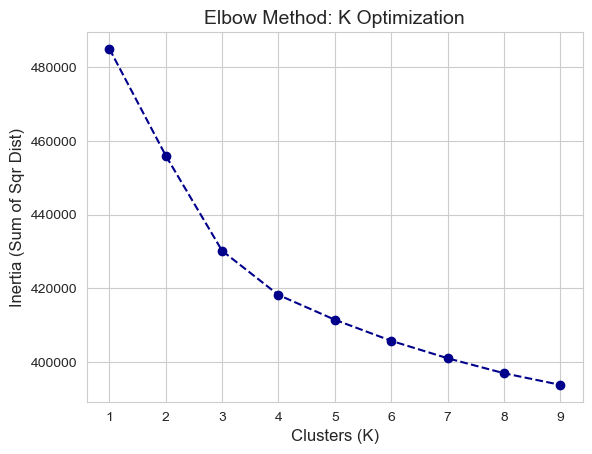

In [25]:
#Inertia Object
inertia = []

k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled_dropped)
    inertia.append(kmeans.inertia_)

# Plo
plt.plot(k_range, inertia, marker='o', color='darkblue', linestyle='--')
plt.title('Elbow Method: K Optimization', fontsize=14)
plt.xlabel('Clusters (K)', fontsize=12); plt.ylabel('Inertia (Sum of Sqr Dist)', fontsize=12)
plt.grid(True); plt.show()



### Cluster nhanes

In [26]:
np.random.seed(10)
# Initialize KMeans
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled_dropped)

In [27]:
# Fitting the KMeans model on the dataset, leaving out the outcome variable
nhanes_scaled_dropped['Cluster'] = kmeans.labels_

# Generating a DataFrame for the cluster centers
cluster_centers_df = pd.DataFrame(data=kmeans.cluster_centers_, 
                                  columns=nhanes_scaled_dropped.columns[:-1])

# Displaying the calculated cluster centers
print("Cluster Centers:")
print(cluster_centers_df)

Cluster Centers:
   DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0       0.0 -0.001403    0.0  0.027785  0.176059 -0.025422 -0.011846   
1       0.0  0.031854    0.0  0.063039 -0.034526  0.046707 -0.085075   
2       0.0 -0.025545    0.0 -0.126271 -0.066961  0.011318  0.069053   
3       0.0 -0.049580    0.0  0.139197  0.019053 -0.216630  0.166909   

   DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845   PAAQUEX  \
0  0.012097  0.001522 -0.033369  ... -0.104709  0.107980 -0.121219 -0.045515   
1 -0.057306  0.057865 -0.064511  ... -0.220143  0.215904 -0.228040 -0.148007   
2  0.041747 -0.067232  0.108991  ...  0.055156 -0.184123  0.182986  0.323067   
3  0.083251 -0.014251 -0.047209  ...  1.120207 -0.576401  0.673493 -0.484200   

     SMQ860  SMQ870    SMQ872    SMQ874    SMQ878  SMAQUEX.x  
0 -0.110446     0.0 -0.017969  0.006048 -0.040921   0.002135  
1 -0.333157     0.0  0.233251 -0.076885 -0.182694   0.165583  
2  0.398346     0.0 -0.198804  0

In [28]:
# Displaying the count of data points in each cluster
print("\nDistribution of Data Points in Clusters:")
print(nhanes_scaled_dropped['Cluster'].value_counts())


Distribution of Data Points in Clusters:
Cluster
1    819
2    679
0    401
3    165
Name: count, dtype: int64


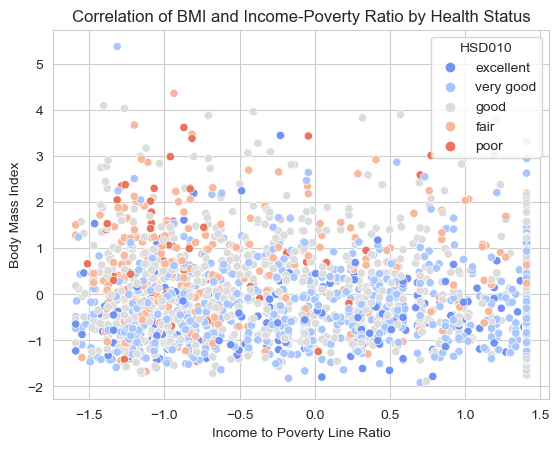

In [29]:
# Creating scatterplot 
ax = sns.scatterplot(
    x="INDFMPIR", 
    y="BMXBMI", 
    hue="HSD010", 
    palette="coolwarm", 
    data=nhanes_scaled)

# Label
ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("Correlation of BMI and Income-Poverty Ratio by Health Status")

# Plot
plt.show()

## Your Answer Here

Reviewing the plot the first thing I thought was that ther were too many clusters used. As is the graph seems uniterpetable. Given previous plots it was probably a better idea to keep the clusters at three despite to other beifets I offered bya dding more. While there does seem to be apatterns where blue dominates the loer right quad while the red dominats the lower left but this may be pushing the interpetation. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [31]:
#train kmeans
kmeans_pca = KMeans(n_clusters=3, n_init=10, max_iter=300).fit(principalComponents_nhanes)

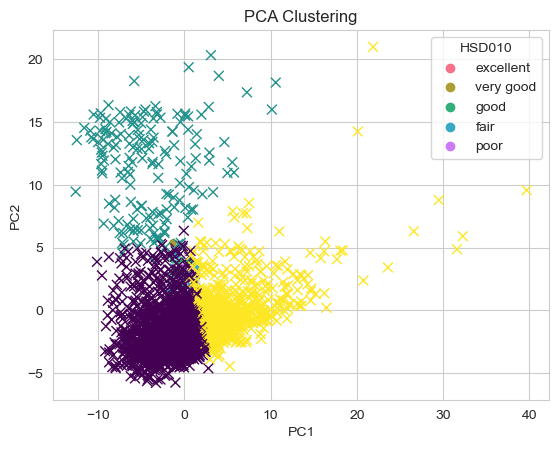

In [36]:
ax = sns.scatterplot(x="INDFMPIR", y="BMXBMI", hue="HSD010", palette="husl", data=nhanes_scaled)

ax.scatter(principalComponents_nhanes[:, 0], principalComponents_nhanes[:, 1], c=kmeans_pca.labels_, cmap='viridis', marker='x', s=50, linewidths=1)


# Labels
ax.set(xlabel="PC1", ylabel="PC2")
ax.set_title("PCA Clustering")

# Displaying the plot
plt.show()

This plot is much more clear boudnaries between clusters.It seems like reeducing the cluster numbers was needed step. Although we still may be concerned about the intesnse overlip between yellow and purple clusters here. While not visually clear one can observe overlap in the clers a great deal. 

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [38]:
# partition data
# -----------

X = nhanes_scaled_dropped
y = nhanes_scaled['HSD010_binary']


label_mapping = {'good': 1, 'poor': 0}
y = y.map(label_mapping)
y = np.array(y)[:, np.newaxis]


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [39]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

model = Sequential()

model.add(Dense(units=2, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

model.add(Dense(units=1,  # Output
                kernel_initializer='normal', 
                activation='sigmoid'))  # Activation

# Add any additional layers you wish here
model.compile(loss='binary_crossentropy', #Cannot use categorical_cross entropy thus we use binary.
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train,                  
          y_train,                 
          validation_data=(X_test,  # Validation
                           y_test), 
          epochs=10,                # Standard number of interations
          batch_size=200,           # Pace
          verbose=2)               

Epoch 1/10
8/8 - 0s - loss: 0.6887 - accuracy: 0.8030 - val_loss: 0.6846 - val_accuracy: 0.8488 - 201ms/epoch - 25ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6821 - accuracy: 0.8359 - val_loss: 0.6771 - val_accuracy: 0.8488 - 11ms/epoch - 1ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6735 - accuracy: 0.8359 - val_loss: 0.6675 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6622 - accuracy: 0.8359 - val_loss: 0.6554 - val_accuracy: 0.8488 - 17ms/epoch - 2ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6484 - accuracy: 0.8359 - val_loss: 0.6408 - val_accuracy: 0.8488 - 16ms/epoch - 2ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6321 - accuracy: 0.8359 - val_loss: 0.6245 - val_accuracy: 0.8488 - 15ms/epoch - 2ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6143 - accuracy: 0.8359 - val_loss: 0.6070 - val_accuracy: 0.8488 - 12ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 0.5956 - accuracy: 0.8359 - val_loss: 0.5892 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 9/10
8/8 - 0s - loss: 0.5766 - a

### Neural Network on Principal Components

In [41]:
# Repeat 


X = pca_df 
X = pca_df.iloc[:, :10]  

#Split again here.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [42]:
model = Sequential()

model.add(Dense(2, 
                input_dim= X_train.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu')) # introduces non-linearity with computational efficiency while mitigating the vanishing gradient problem

model.add(Dense(units=1,  # Output 
kernel_initializer='normal', 
activation='sigmoid'))  


model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

model.fit(X_train,                  
          y_train,                  
          validation_data=(X_test,  # Validation
                           y_test), 
          epochs=10,                
          batch_size=200,           
          verbose=2);               

Epoch 1/10
8/8 - 0s - loss: 0.6912 - accuracy: 0.6660 - val_loss: 0.6889 - val_accuracy: 0.7733 - 162ms/epoch - 20ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6869 - accuracy: 0.8282 - val_loss: 0.6844 - val_accuracy: 0.8488 - 11ms/epoch - 1ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6826 - accuracy: 0.8359 - val_loss: 0.6799 - val_accuracy: 0.8488 - 11ms/epoch - 1ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6781 - accuracy: 0.8359 - val_loss: 0.6752 - val_accuracy: 0.8488 - 12ms/epoch - 1ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6734 - accuracy: 0.8359 - val_loss: 0.6703 - val_accuracy: 0.8488 - 13ms/epoch - 2ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6685 - accuracy: 0.8359 - val_loss: 0.6650 - val_accuracy: 0.8488 - 13ms/epoch - 2ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6632 - accuracy: 0.8359 - val_loss: 0.6593 - val_accuracy: 0.8488 - 18ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6574 - accuracy: 0.8359 - val_loss: 0.6532 - val_accuracy: 0.8488 - 16ms/epoch - 2ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6511 - a

### Neural Network on Principal Components + Cluster Membership

In [43]:
# One more time...
X_pcacluster = np.column_stack((X, nhanes_scaled_dropped['Cluster']))

X_train, X_test, y_train, y_test = train_test_split(X_pcacluster, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [44]:
model = Sequential()

model.add(Dense(2, 
                input_dim= X_train.shape[1], 
                kernel_initializer= 'normal', 
                activation= 'relu')) # introduces non-linearity with computational efficiency while mitigating the vanishing gradient problem

model.add(Dense(units=1,  # Output
kernel_initializer='normal', 
activation='sigmoid'))  

# Add any additional layers you wish here
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train,                  
          y_train,                  
          validation_data=(X_test,  # Validation
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)

Epoch 1/10
8/8 - 0s - loss: 0.6881 - accuracy: 0.8107 - val_loss: 0.6855 - val_accuracy: 0.8488 - 161ms/epoch - 20ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6837 - accuracy: 0.8359 - val_loss: 0.6808 - val_accuracy: 0.8488 - 11ms/epoch - 1ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6787 - accuracy: 0.8359 - val_loss: 0.6755 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6733 - accuracy: 0.8359 - val_loss: 0.6697 - val_accuracy: 0.8488 - 15ms/epoch - 2ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6673 - accuracy: 0.8359 - val_loss: 0.6632 - val_accuracy: 0.8488 - 15ms/epoch - 2ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6607 - accuracy: 0.8359 - val_loss: 0.6561 - val_accuracy: 0.8488 - 16ms/epoch - 2ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6535 - accuracy: 0.8359 - val_loss: 0.6484 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6456 - accuracy: 0.8359 - val_loss: 0.6402 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6370 - a

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA seeks to find the orthogonal axes in the "data space along which the data variance is maximized", effectively redefining the data's coordinate system (Dr. Lexin Li). This process reduces the dimensionality by projecting the data onto these axes, starting with the one that captures the most variance. In cases of multicollinearity, PCA provides a set of uncorrelated variables (principal components), which simplifies the analysis and helps in overcoming the issues caused by multicollinearity in regression models or other statistical analyses. Clustering is an unsupervised learning technique that groups data points into distinct subsets or clusters, based on their inherent similarities. This process involves measuring the likeness between data points, typically through distance metrics, and organizing them such that those within each cluster are more alike to each other than to those in other clusters. 

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

In my analysis combining PCA with clustering, I observed some advantages, especially in creating distinct cluster boundaries. The uncorrelated nature of PCA components makes them ideal for clustering algorithms, which thrive on distinctly differentiable features. However, I also noticed a trade-off: while PCA simplified the data, reducing it to three principal components seemed to omit critical explanatory features. In smaller datasets like the one I used, the benefits of PCA and clustering were less pronounced, implying that their effectiveness is more apparent in larger, more complex datasets ( or even perhaps with differents sets of questions in the surveys.)

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Clustering and dimensionality reduction play a crucial role in enhancing the performance of downstream supervised learning tasks. When dealing with massive datasets, these techniques can unearth underlying patterns and structures that are not immediately apparent. For instance, unsupervised learning can identify natural groupings or segments in the data, which can be invaluable for feature engineering in supervised models. This segmentation can lead to the creation of new, meaningful features or the transformation of existing ones, thereby improving the dataset with more informative variables for subsequent prediction.

Additionally, unsupervised methods can be instrumental in data cleaning and preprocessing stages. They can help in detecting outliers or anomalies, which, if left unchecked, can skew the results of supervised models. By flagging or removing these anomalies, the data becomes more robust and reliable for training predictive models.Moreover, in scenarios where labeled data is scarce or expensive to obtain, unsupervised techniques can provide an initial understanding or structure to the dataset. This structure can then guide the supervised learning process, making it more efficient.